## **Objective:**
Predict if customers will repurchase specific products to optimize inventory and personalize marketing.

**Business Impact:** Reduce waste, improve customer retention, and increase revenue for CPG companies.

## Data Overview

In [ ]:
# !pip install -q skimpy jupyter-summarytools

In [33]:
import pandas as pd
import numpy as np
from skimpy import skim
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Load data
df = pd.read_csv('repeat_purchase_data.csv')
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1000   │ │ int64       │ 4     │                                                          │
│ │ Number of columns │ 7      │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ │ string      │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column                 ┃ NA  ┃ NA %  ┃ mean   ┃ sd      ┃ p0     ┃ p25    ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ customer_id            │   0 │     0 │  251.7 │   141.8 │      1 │  134.8 │   247 │   374 │   500 │ ▆██▇█▇ │  │
│ │ product_id             │   0 │     0 │  25.69 │   14.43 │      1 │     13 │    26 │    38 │    50 │ █▇▇▇██ │  │
│ │ days_since_last_order  │  50 │     5 │  43.09 │    26.1 │      1 │     21 │  41.5 │    66 │    89 │ █▇▇▆▆▇ │  │
│ │ order_count            │   0 │     0 │  5.016 │   2.567 │      1 │      3 │     5 │     7 │     9 │ ▇▄▄█▃█ │  │
│ │ avg_order_size         │   0 │     0 │   56.9 │   25.44 │  10.04 │  36.45 │ 57.81 │ 78.69 │ 99.96 │ ▆▆███▇ │  │
│ │ will_repurchase        │   0 │     0 │  0.307 │  0.4615 │      0 │      0 │     0 │     1 │     1 │ █    ▄ │  │
│ └────────────────────────┴─────┴───────┴────────┴─────────┴────────┴────────┴───────┴───────┴───────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓  │
│ ┃             ┃    ┃      ┃          ┃           ┃        ┃        ┃ chars per   ┃ words per   ┃             ┃  │
│ ┃ column      ┃ NA ┃ NA % ┃ shortest ┃ longest   ┃ min    ┃ max    ┃ row         ┃ row         ┃ total words ┃  │
│ ┡━━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩  │
│ │ product_cat │ 67 │  6.7 │ dairy    │ beverages │ bakery │ snacks │        6.37 │        0.93 │         933 │  │
│ │ egory       │    │      │          │           │        │        │             │             │             │  │
│ └─────────────┴────┴──────┴──────────┴───────────┴────────┴────────┴─────────────┴─────────────┴─────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

## Data Preprocessing
Handle Missing Values

In [10]:
# Fill missing numerical values with median
df['days_since_last_order'] = df['days_since_last_order'].fillna(
    df['days_since_last_order'].median()
)

# Fill missing categorical values with 'unknown'
df['product_category'] = df['product_category'].fillna('unknown')

In [20]:
df.isnull().sum()

,0
customer_id,0
product_id,0
days_since_last_order,0
order_count,0
avg_order_size,0
will_repurchase,0
loyalty_score,0
cat_bakery,0
cat_beverages,0
cat_cereal,0


Feature Engineering

In [11]:
# Create a "loyalty" score (higher order count → more loyal)
df['loyalty_score'] = df['order_count'] / df['order_count'].max()

# One-hot encode product categories
df = pd.get_dummies(df, columns=['product_category'], prefix='cat')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            1000 non-null   int64  
 1   product_id             1000 non-null   int64  
 2   days_since_last_order  1000 non-null   float64
 3   order_count            1000 non-null   int64  
 4   avg_order_size         1000 non-null   float64
 5   will_repurchase        1000 non-null   int64  
 6   loyalty_score          1000 non-null   float64
 7   cat_bakery             1000 non-null   bool   
 8   cat_beverages          1000 non-null   bool   
 9   cat_cereal             1000 non-null   bool   
 10  cat_dairy              1000 non-null   bool   
 11  cat_snacks             1000 non-null   bool   
 12  cat_unknown            1000 non-null   bool   
dtypes: bool(6), float64(3), int64(4)
memory usage: 60.7 KB


## Train-Test Split

In [12]:
# Drop IDs (not features)
X = df.drop(['will_repurchase', 'customer_id', 'product_id'], axis=1)
y = df['will_repurchase']

# Split with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Exploratory Data Analysis (EDA)
Target Distribution

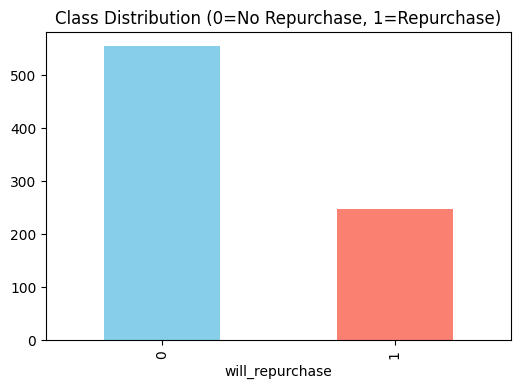

In [14]:
plt.figure(figsize=(6, 4))
y_train.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution (0=No Repurchase, 1=Repurchase)')
plt.show()

## Model Training

XGBoost

In [42]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train XGBoost
xgb_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1
)
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Evaluation
Metrics

In [43]:
# XGBoost
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost with SMOTE:\n", classification_report(y_test, y_pred_xgb))

XGBoost with SMOTE:
               precision    recall  f1-score   support

           0       0.71      0.79      0.75       139
           1       0.37      0.28      0.32        61

    accuracy                           0.64       200
   macro avg       0.54      0.54      0.53       200
weighted avg       0.61      0.64      0.62       200

